In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch and Lightning
import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

# Utilities
import logging
from tqdm import tqdm

# Calvera bandit library
from calvera.bandits import NeuralUCBBandit
from calvera.benchmark.datasets import StatlogDataset
from calvera.utils import InMemoryDataBuffer, AllDataRetrievalStrategy
from calvera.benchmark import BanditBenchmarkEnvironment
from calvera.benchmark import OnlineBanditLoggerDecorator

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
# Load the MNIST dataset
dataset = StatlogDataset()

# Print dataset information
print(f"Context dimension size: {dataset.context_size}")
print(f"Total number of samples: {len(dataset)}")

Context dimension size: 63
Total number of samples: 58000


In [4]:
# Configuration
HIDDEN_SIZE = 100
NUM_SAMPLES = 10000
BATCH_SIZE = 32

# Create memory buffer to store experiences
buffer = InMemoryDataBuffer(
    retrieval_strategy=AllDataRetrievalStrategy(),
    max_size=NUM_SAMPLES,
)

# Initialize neural network
network = Network(dataset.context_size, hidden_size=HIDDEN_SIZE)

# Create data loader with a subset of the dataset
train_loader = DataLoader(Subset(dataset, range(NUM_SAMPLES)), batch_size=BATCH_SIZE, shuffle=True)

# Initialize the bandit environment
env = BanditBenchmarkEnvironment(train_loader)

# Initialize the NeuralUCBBandit module
bandit_module = NeuralUCBBandit(
    n_features=dataset.context_size,
    network=network,
    buffer=buffer,
    train_batch_size=BATCH_SIZE,
    early_stop_threshold=1e-3,
    weight_decay=0.00001,
    exploration_rate=0.00001,
    learning_rate=1e-3,
    min_samples_required_for_training=32,
    initial_train_steps=2048,
)

# Configure logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(
    CSVLogger("logs", name="neural_ucb_bandit", flush_logs_every_n_steps=100),
    enable_console_logging=False,
)

In [5]:
# Initialize arrays to store metrics
rewards = np.array([])
regrets = np.array([])

# Training loop with progress bar
progress_bar = tqdm(iter(env), total=len(env), desc="Training Neural UCB bandit")
for contextualized_actions in progress_bar:
    # Select actions based on current model
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    # Set up trainer for this step
    trainer = pl.Trainer(
        max_epochs=1,
        max_steps=1024,
        logger=logger,
        gradient_clip_val=20.0,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
    )

    # Get feedback and compute regret
    chosen_contextualized_actions, realized_rewards = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)

    # Record metrics
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    # Update progress bar with current metrics
    progress_bar.set_postfix(
        reward=realized_rewards.sum(dim=1).mean().item(),  # shape batch_size, selected_arms
        regret=batch_regret.mean().item(),
        average_regret=regrets.mean(),
    )

    # Update the bandit with feedback
    bandit_module.record_feedback(chosen_contextualized_actions, realized_rewards)
    trainer.fit(bandit_module)

# Create DataFrame with collected metrics
metrics = pd.DataFrame(
    {
        "reward": rewards,
        "regret": regrets,
    }
)

# Display the first few rows of metrics
metrics.head()

Training Neural UCB bandit: 100%|██████████| 313/313 [04:19<00:00,  1.21it/s, average_regret=0.0651, regret=0, reward=1]


,reward,regret
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


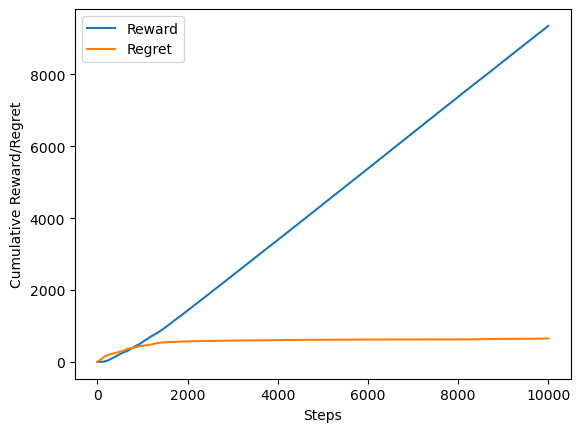

In [6]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative regret and reward
plt.plot(cumulative_reward, label="Reward")
plt.plot(cumulative_regret, label="Regret")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward/Regret")
plt.legend()
plt.show()

In [7]:
# Calculate metrics for each time horizon
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.1000
Average reward (first 100 rounds): 0.0500
Average reward (all rounds): 0.9349

Average regret (first 10 rounds): 0.9000
Average regret (first 100 rounds): 0.9500
Average regret (all rounds): 0.0651


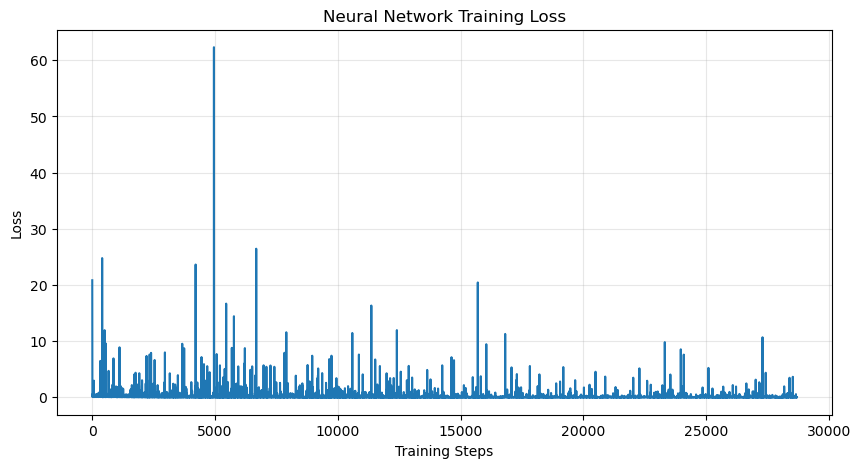

In [8]:
# Load the training metrics
bandit_metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
bandit_metrics = pd.read_csv(bandit_metrics_csv)

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(bandit_metrics["loss"])
plt.title("Neural Network Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.show()